# California Solar
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/notebooks/ca-solar/main.ipynb)._]

In January 2020, a California mandate went into effect requiring solar panels in new construction.  Even before 2020, and certainly since, solar panel adoption increased year after year.  But at the same time, California has been suffering from [increasingly bad wildfires](https://www.cnbc.com/2020/09/18/fires-in-california-oregon-and-washington-data-shows-blazes-getting-worse-.html).  The impact of these fires were summarized in an [EIA white paper](https://www.eia.gov/todayinenergy/detail.php?id=45336#) and other articles, like this one detailing the [impact of California fires on Colorado air quality](https://coloradosun.com/2021/08/25/california-wildfire-smoke-health-hazard-colorado/).

To demonstrate some of the impact wildfires have had, we'll take a look at California solar GHI data, combined with wildfire data, to show how GHI has been reduced during these fires to lower than expected levels, thus reducing the potential energy solar panels can generate.

This notebook is demonstrative and thus will be make several naive assumptions (these will be clearly outlined).  For a more indepth example of the the type of work around GHI data and solar potential, see this paper on [Modeling Solar Irradiance](https://journals.ametsoc.org/view/journals/apme/56/1/jamc-d-16-0175.1.xmlhttps://journals.ametsoc.org/view/journals/apme/56/1/jamc-d-16-0175.1.xml)

GHI, or General Horizontal Irradiance, is the [combination of Direct Normal (adjusted for solar angle) and Diffuse Irradiance](https://en.wikipedia.org/wiki/Solar_irradiance) (DNI and DHI, respectively).  Direct Normal Irradiance comes from direct solar light, barring any reflection or loss.  Diffuse Irradiance comes from the atmospherically reflected solar light--much like how on a cloudy day there is still light available to see.  Solar panels charge via the availability of both DNI and DHI--though more efficiently via DNI--so GHI can be used to capture overall solar potential.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=ca-solar" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

### Preparation

In [1]:
import atoti as tt
import numpy as np
import pandas as pd

In [2]:
from datetime import date

While the wildfires are primarily located in California, wind patterns mean the smoke from a California fire can also impact neighboring states.  Further, if smoke particulate reaches a high enough altitude, these particles can travel more generally.

Given this, this notebook and the NREL data gathering python script are structured so GHI data for other states can just as easily be downloaded and studied.

In [3]:
state = "California"
time = "20"
start = 2016
end = 2021

For the purpose of this notebook, we'll be focusing on the State of California and using +20UTC time data, or noon standard time in California.  This is when the sun is near to its zenith, thus around the time when GHI is likely to be at a daily peak, barring cloudiness and such.  

Each file has only one year's worth of data, so we'll load each one in and concatenate them to create one dataframe for the whole time range.  The process by which this data was sourced from the NREL database is documented in the 01-nrel-data-sourcing python script.

In [4]:
ghi_df = pd.read_feather(
    f"https://data.atoti.io/notebooks/ca-solar/nsrdb_{start}_{state}_{time}UTC_GHI.feather"
)

for year in range(start + 1, end):
    df = pd.read_feather(
        f"https://data.atoti.io/notebooks/ca-solar/nsrdb_{year}_{state}_{time}UTC_GHI.feather"
    )
    ghi_df = pd.concat([ghi_df, df], ignore_index=True)

ghi_df.head()

,datetime,Station,ghi
0,2016-01-01 20:00:00,station_000071236,598.0
1,2016-01-02 20:00:00,station_000071236,483.0
2,2016-01-03 20:00:00,station_000071236,586.0
3,2016-01-04 20:00:00,station_000071236,101.0
4,2016-01-05 20:00:00,station_000071236,91.0


Since we are taking GHI data from 20:00UTC time, the time component in our datetime column is a bit redundant.  We'll parse out the date portion and delete the datetime column.

In [5]:
ghi_df["Date"] = [d.date() for d in ghi_df["datetime"]]
del ghi_df["datetime"]

ghi_df.head()

,Station,ghi,Date
0,station_000071236,598.0,2016-01-01
1,station_000071236,483.0,2016-01-02
2,station_000071236,586.0,2016-01-03
3,station_000071236,101.0,2016-01-04
4,station_000071236,91.0,2016-01-05


The latitudes and longitudes for the solar data were also sourced from the NREL database and saved to a separate file.

The fire data was sourced from [fire.ca.gov](https://www.fire.ca.gov/), stored as a json for each year.  The separate jsons were merged into a single dataframe, which was saved as a feather file.  This process is documented in the 02-fire-data-sourcing python script.

In [6]:
fire_loc_df = pd.read_feather(
    "https://data.atoti.io/notebooks/ca-solar/fire_loc.feather"
)
distance_df = pd.read_feather(
    "https://data.atoti.io/notebooks/ca-solar/distance.feather"
)
fire_data_df = pd.read_feather(
    "https://data.atoti.io/notebooks/ca-solar/fire_data.feather"
)
station_df = pd.read_feather(
    f"https://data.atoti.io/notebooks/ca-solar/nsrdb_station_lat_lon.feather"
)

### Loading and joining the Data

Having each dataframe ready, we'll jump right in to creating our cube for exploration.  We'll keep the dataframes separate and join them together within our session.

In [7]:
session = tt.Session()

In [8]:
ghi = session.read_pandas(ghi_df, table_name="ghi", keys=["Date", "Station"])

In [9]:
lat_lon = session.read_pandas(station_df, table_name="lat_lon", keys=["Station"])
fire_data = session.read_pandas(fire_data_df, table_name="fire_data")
fire_loc = session.read_pandas(fire_loc_df, table_name="fire_loc")
distance = session.read_pandas(
    distance_df, table_name="distance", keys=["Station", "Fire"]
)

In [10]:
cube = session.create_cube(ghi, mode="no_measures")

Though the cube was created from the GHI table data, we can join in the other tables and see the cube schema reflect the additional joins.

In [11]:
ghi.join(lat_lon, mapping={"Station": "Station"})
ghi.join(distance, mapping={"Station": "Station"})
distance.join(fire_data, mapping={"Fire": "Fire"})
fire_data.join(fire_loc, mapping={"Fire": "Fire"})

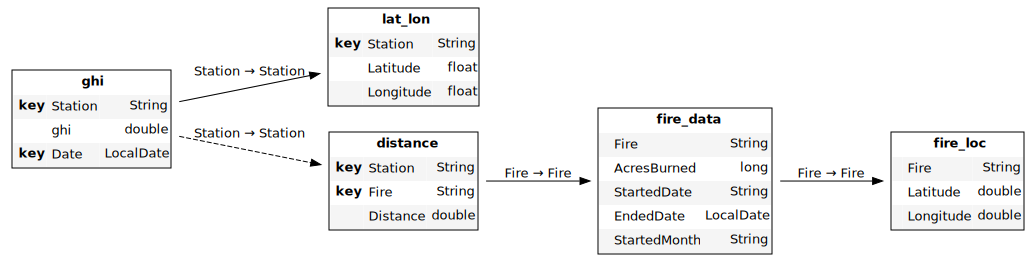

In [12]:
cube.schema

In [13]:
cube

Cube(_name='ghi', _hierarchies=Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of ...>, _cube_name='ghi'), _measures=Measures())

In [14]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Exploring the GHI data

Our data is distributed across many tables, and we created our cube with no measures so we could control which measures and aggregations we create.  Let's begin with reading some of the data, like latitude and longitudes and the GHI data, and create hierarchies from our date information.

In [15]:
m["Latitude"] = tt.value(lat_lon["Latitude"], levels=[l["Station"]])
m["Longitude"] = tt.value(lat_lon["Longitude"], levels=[l["Station"]])

m["ghi.MEAN"] = tt.agg.mean(ghi["ghi"])
m["ghi.MIN"] = tt.agg.min(ghi["ghi"])
m["ghi.MAX"] = tt.agg.max(ghi["ghi"])

In [16]:
m["FireLat"] = tt.value(fire_loc["Latitude"], levels=[l["Fire"]])
m["FireLon"] = tt.value(fire_loc["Longitude"], levels=[l["Fire"]])

In [17]:
cube.create_date_hierarchy(
    "calendar",
    column=ghi["Date"],
    levels={"year": "YYYY", "month": "MM"},
)

h["calendar"] = {**h["calendar"].levels, "Date": ghi["Date"]}

There are two distinct sets of atitude and longitude data.  The station data sourced from NREL covers the full state of California in a grid like manner.  Fires may not necessarily cover the entire state.  However, looking at the fire data, over the five years it does look like fires occur nearly everywhere.

In [18]:
# Uncomment to visualize locations
# session.visualize("Station locations")

In [19]:
# Uncomment to visualize locations
# session.visualize("Fire locations")

GHI roughly follows a sinusoid-like pattern, though the precise curve predicting GHI is [far more complicated than just that](https://www.researchgate.net/publication/336054301_A_sinusoidal_model_to_assess_PV_generation_from_daily_irradiation_data). For simplicity, we'll use a basic sine or cosine curve.  Since January 1st is relatively close to the winter solstice, the anticipated GHI shape should look very much like a negative cosine curve.

We'll create an "expected" ghi curve given by $ghi(n) = B - A * \cos \frac{2 \pi (n + \phi)}{365.25}$, where  
-$\phi$ is the phase shift (in days), based off 2015's winter solstice date  
-n is time (in days) starting from the beginning of 2016  
-A is the amplitude  
-B is the vertical shift  

To compute compute A and B, we'll look at solstice date for our GHI values, which occurs at the end of June.

In [20]:
session.visualize("GHI around summer solstices")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

It looks like the GHI data around summer solstice should be over 1000.  Checking the number of fires which started in June, it is possible the GHI data is supressed due to smoke.

In [21]:
session.visualize("List of fires which started in June")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Given the fire situation, we'll use a GHI value slightly higher than the average across the five solstices for our peak value--say 1050, which is nearly the 2018 mean GHI, and below the average maximum GHI.

Similarly, we'll consider the average winter solstice GHI.

In [22]:
session.visualize("GHI around winter solstices")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [23]:
A = (1050 - 419) / 2  # amplitude
phi = 10  # offset from 2015's winter solstice
B = 419 + A  # vertical shift

m["ghi_exp"] = B - A * tt.math.cos(
    2
    * np.pi
    * (tt.date_diff(date(2016, 1, 1), l[("ghi", "Date", "Date")]) + phi)
    / 365.25
)

# creating the delta check
m["GHI diff"] = m["ghi.MEAN"] - m["ghi_exp"]

From this, we get the following expected GHI curve, compared to the mean GHI data.

In [24]:
session.visualize("Mean GHI over time")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Visualizing the Impact

We expect some noise in our GHI data, but comparing it to the expected curve, we can see some segments where there are deviations or "divets" in the curve, such as around July 2017, July 2018, and even March 2020.  Let's see if there are many fires around those times, and let's also see what stations are impacted by either those fires, or other fires.

Let's start with the GHI difference for across a few years.  From below, we can see our model generally under predicts GHI (ghi.MEAN nearly fully covers the expected curve). However, there is also a very clear dip in mean GHI around July 2017, 2018, 2019 where more blue than usual is visible in the graph.

In [25]:
session.visualize("GHI diff across years")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's consider July of 2018.  If the entire month of July experiences below expected GHI, then homes in this area would have had less solar irradiance than projected.

We'll start by seeing how many stations have been close to fires.  Since the locations are given by latitude and longitude, the distance will be by degrees.  We'll use just under 0.1 degree distance as our definiton of "nearby".  This is assuming a spherical earth, since one degree longtitude is not equal to one degree latitude in the oblate-spheroidal case.

In [26]:
m["distance"] = tt.value(
    distance["Distance"], levels={l["Station"], l[("distance", "Fire", "Fire")]}
)

In [27]:
m["NearbyFires.COUNT"] = tt.agg.sum(
    tt.where(m["distance"] < 0.07, 1, 0), scope=tt.scope.origin(l["Station"])
)

In [28]:
session.visualize("Stations frequently near fires")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

There are 132 stations which have had more than 5 fires nearby in the past five years.  Let's look at the GHI data for one of the stations that has been near 9 fires.  More so than the overall GHI mean curve, it has quite a few places where there seems to be lost irradiance.

In [29]:
session.visualize("Station 81635")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's look a bit more thoroughly how much irradiance is lost by comparing the actual GHI to the expected during one of these "rough" July patches.

In [30]:
session.visualize("Station 81635 actual vs expected GHI difference, July 2017")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

And similarly for the 2018 rough patch:

In [31]:
session.visualize("Station 81635 actual vs expected GHI difference, July 2018")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

And we can even look at the state of California overall for July 2018--which from our earlier visual, we expected to be greatly negative as well.

In [32]:
session.visualize("California actual vs expected GHI difference, July 2018")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Indeed, it looks like something significantly and negatively impacted the GHI for July of 2018.

To understand what might be causing this, let's look at the fire data, including how many acres these fires burned, and when.

In [33]:
m["AcresBurned"] = tt.value(
    fire_data["AcresBurned"],
)

m["AcresBurned.SUM"] = tt.agg.sum(m["AcresBurned"], scope=tt.scope.origin(l["Fire"]))

In [34]:
session.visualize("Acres burned based off month")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

By this, we see the vast majority acreage is burned by the fires which begin in July and August.  In fact, looking at the below graph over time, there are three significant jumps in burned acreage:  around July 2017, July 2018, and July 2020.

In [35]:
session.visualize("Acres burned by started date")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's see what fires caused these significant jumps.

In [36]:
session.visualize("20 largest fires, and when they burned")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [37]:
len(fire_data)

1362

Even though there are over 1300 fires in our fire dataset, 20 fires account for nearly 2/3s the total acres burned (nearly 4.1m out of just over 6m acres burned!), and they predominently take place in the months of July and August.  This is in line with the depressed GHI data we see.

### Solar potential loss

Depending on the technololgy used, solar panel technology is capable of converting anywhere from 20-50% of available GHI to usable solar energy.  The approximate kilowatt and accumultaed kilowatt-hour output one can expect is given by  
$kW = ghi \cdot Area \cdot P$  
and  
$kWh (n,t) = \sum_n \int ghi_n(t) \cdot Area \cdot P \, \mathrm{d} t $  
where   
-$n$ is days  
-$ghi_n(t)$ is the function of varying ghi value over time throughout one day 
-Area is the Area of solar panel,  
-$P$ is the performance efficiency.  

For the sake of this notebook, we'll assume 35% efficiency for $P$.

Since we've only sourced noon data, we would have to estimate the daily variation in GHI by a sine function.  Though not perfectly sinusoidal, we can use the following to model:  
$ghi_n(t) = GHI_{n}\cdot\sin(\frac{\pi t}{H})$  
where t is the time from sunrise to sunset, and H is the total daylight hours for the day.  

There are roughly 14 hours of daylight in California during the month of July.  Using this, we can compute the integral of the sine function, leaving the summand over days for computing potential kilowatt hours.

$kW h (n,t) = \sum_n \int ghi_n(t) \cdot Area \cdot P \,\mathrm{d}t $   
$kW h (n,t) = \sum_n \int GHI_{n} \cdot \sin(\frac{\pi t}{14}) \cdot Area \cdot P \,\mathrm{d}t $  
$kW h (n,t) = \sum_n GHI_{n} \cdot Area \cdot P \int \sin(\frac{\pi t}{14}) \,\mathrm{d}t $  
$kW h (n) = \sum_n GHI_{n} \cdot Area \cdot P [-\frac{14}{\pi}\cos(\frac{\pi t}{14})]_0^{14} = \sum_n \frac{28\cdot Area \cdot P}{\pi} \cdot GHI_{n}$  


In [38]:
P = 0.35  # setting solar loss

In [39]:
m["kWhours/Area_exp"] = tt.agg.sum(
    28 * P / (np.pi) * m["ghi_exp"],
    scope=tt.scope.cumulative(l[("ghi", "Date", "Date")]),
)
m["kWhours/Area"] = tt.agg.sum(
    28 * P / (np.pi) * m["ghi.MEAN"],
    scope=tt.scope.cumulative(l[("ghi", "Date", "Date")]),
)

In [40]:
session.visualize("Cummulative kW hrs per solar panel area")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

So, how much potential energy generation do we lose in July?

In [41]:
m["kWhours/Area_diff"] = m["kWhours/Area"] - m["kWhours/Area_exp"]

In [42]:
session.visualize("Average lost potential in July")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [43]:
session.visualize("July daily loss for station 81635")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In 2018, we see we lost nearly 16 MWhr per solar panel area near Station 81635!  Given the month's expected potential was around 100 MWhr, this represents about 16% lost potential for homes in that area.

### What If?

What if there were fewer fires in July, such that we weren't experiencing dampened GHI?  How would that impact our solar potential?  We can investigate these by creating different scenarios.

Let's create a scenario which assumes solar data remains exactly as is for the remainder of the year but behaves according to the (still an underestimate!) expected curve during the months of July.  How would that impact the solar energy potential?

In [44]:
ghi_simulation = cube.create_parameter_simulation(
    "GHI Simulation",
    measures={"ghi_param": 0},
    levels=[l[("ghi", "Date", "Date")]],
)

In [45]:
m["ghi_sim"] = m["ghi.MEAN"] - m["ghi_param"] * m["GHI diff"]
m["kWhours/Area_sim"] = tt.agg.sum(
    28 * P / (np.pi) * m["ghi_sim"],
    scope=tt.scope.cumulative(l[("ghi", "Date", "Date")]),
)

In [46]:
for year in range(2016, 2021):
    for day in range(1, 32):
        ghi_simulation += ("July Replaced", date(year, 7, day), 1)

In [47]:
session.visualize(
    "Impact of replacing July GHI with expected for station 81635 over time"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

As documented in numerous news articles and research papers, there is a demonstrable impact of California wildfires on GHI and thus potential solar energy generation.  Through this notebook, we were able to analyze the existing data to determine where fires were impactful, then could run simulations to determine loss and future potential.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=ca-solar" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>